In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, LabelEncoder

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score, roc_curve
from sklearn.inspection import permutation_importance

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

#!pip install prettytable
from prettytable import PrettyTable


## Part 1
* Predicting race from police dept features (police demographics, policies) etc.
* Database: victim_lemas_only1208.csv

In [23]:
random_state = 109

# load data
data = pd.read_csv('data/victim_lemas_only1208.csv')
response, multi_class = 'race', True
total = len(data)

# drop unnecessary columns
cols_to_drop = ['date', 'city_wapo', 'state', 'AGENCYNAME'] + list(data.filter(regex='PERS'))
data = data.drop(cols_to_drop, axis=1)

# drop nas
data = data.dropna()
print(f'Number of victims missing values: {total-len(data)}')

# convert booleans to integers
# bools_to_ints = ['signs_of_mental_illness', 'body_camera']
# data[bools_to_ints] = data[bools_to_ints].astype(int)

# print proportion of each race in the dataset
baseline_race=data.groupby('race')['race'].value_counts()/len(data)
display(baseline_race)
print(f'A baseline model predicting everyone as white would have accuracy of {max(baseline_race.values)}')

# convert response variable to 0 and n_classes-1
if multi_class:
    le = LabelEncoder()
    data[response] = le.fit_transform(data[response])
    print(f'Response variable classes: {le.classes_}')

# convert other variables to dummies
# data = pd.get_dummies(data)
data.dtypes

Number of victims missing values: 0


race  race
A     A       0.017022
B     B       0.294914
H     H       0.173503
N     N       0.012510
O     O       0.009639
W     W       0.492412
Name: race, dtype: float64

A baseline model predicting everyone as white would have accuracy of 0.4924118129614438
Response variable classes: ['A' 'B' 'H' 'N' 'O' 'W']


race                  int64
body_camera           int64
POL_BWC             float64
POL_COMP_EXTINV     float64
POL_INV_INJRY       float64
POL_INV_DTH         float64
POL_INV_DCHG_GUN    float64
FRAC_WHITE          float64
FRAC_BLACK          float64
FRAC_HISP           float64
FRAC_AMIND          float64
FRAC_ASIAN          float64
FRAC_HAWPI          float64
FRAC_MULTI          float64
FRAC_UNK            float64
dtype: object

In [4]:
# splits
rows = len(data)
train_size = 0.6
val_size = 0.2

train, validate, test = np.split(data.sample(frac=1, random_state=random_state), [int(train_size*rows), int((train_size+val_size)*rows)])

x_train, y_train = train.drop(response, axis=1), train[response]
x_val, y_val = validate.drop(response, axis=1), validate[response]
x_test, y_test = test.drop(response, axis=1), test[response]

col_labels = x_train.columns

scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

print(f'Train size: {len(train)/rows:.2f}')
print(f'Val size: {len(validate)/rows:.2f}')
print(f'Test size: {len(test)/rows:.2f}')

Train size: 0.60
Val size: 0.20
Test size: 0.20


In [5]:
# model fitting
class Model():
    def __init__(self, model):
        self.model = model.fit(x_train, y_train)
    
    def train_accuracy(self):
        return self.model.score(x_train, y_train)
        
    def validation_accuracy(self):
        return self.model.score(x_val, y_val)

    def test_accuracy(self):
        return self.model.score(x_test, y_test)
    
    def importance(self):
        pi = permutation_importance(self.model, x_train, y_train, random_state=random_state)
        
        plt.figure(figsize=(5,5))
        
        sorted_idx = np.argsort(pi.importances_mean)[-10:]
        indices = np.arange(0, len(pi.importances_mean[-10:])) + 0.5
        
        plt.barh(indices, pi.importances_mean[sorted_idx], height=0.7)
        plt.yticks(indices, col_labels[sorted_idx])
        plt.ylim((0, len(pi.importances_mean[-10:])))
        plt.xlabel("Permutation Feature Importance")
        plt.title(f'{type(self.model).__name__}')
    
    def roc(self):
        proba = self.model.predict_proba(x_train)[:,1]
        return roc_curve(y_train, proba)

knn = Model(KNeighborsClassifier())

logit = Model(LogisticRegression(multi_class='ovr', max_iter=1000, random_state=random_state))
logitCV = Model(LogisticRegressionCV(multi_class='ovr', max_iter=1000, random_state=random_state))

dtree = Model(DecisionTreeClassifier(random_state=random_state))
forest = Model(RandomForestClassifier(random_state=random_state))
boost = Model(AdaBoostClassifier(random_state=random_state))

models = [knn, logit, logitCV, dtree, forest, boost]

In [6]:
x = PrettyTable()
x.field_names = ["Model", "Train Accuracy", "Validation Accuracy"]
x.add_rows(
    [
        ["KNN", knn.train_accuracy(), knn.validation_accuracy()],
        ["Logistic Regression", logit.train_accuracy(), logit.validation_accuracy()],
        ["Logistic Regression CV", logitCV.train_accuracy(), logitCV.validation_accuracy()],
        ["Decision Tree", dtree.train_accuracy(), dtree.validation_accuracy()],
        ["Random Forest", forest.train_accuracy(), forest.validation_accuracy()],
        ["AdaBoost", boost.train_accuracy(), boost.validation_accuracy()]
    ]
)

x.align = "l"
x.float_format = '.3'

print('Accuracies for victim_lemas_only1208.csv')
print(x)

Accuracies for victim_lemas_only1208.csv
+------------------------+----------------+---------------------+
| Model                  | Train Accuracy | Validation Accuracy |
+------------------------+----------------+---------------------+
| KNN                    | 0.649          | 0.543               |
| Logistic Regression    | 0.592          | 0.587               |
| Logistic Regression CV | 0.587          | 0.585               |
| Decision Tree          | 0.752          | 0.538               |
| Random Forest          | 0.752          | 0.568               |
| AdaBoost               | 0.573          | 0.571               |
+------------------------+----------------+---------------------+


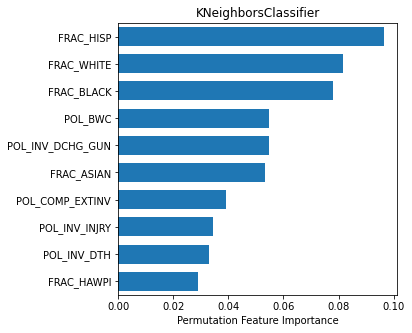

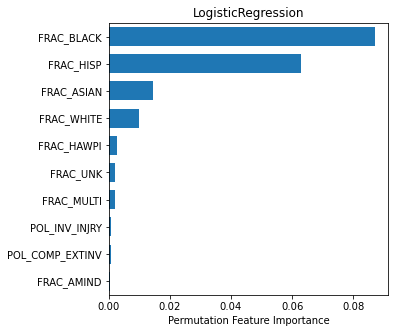

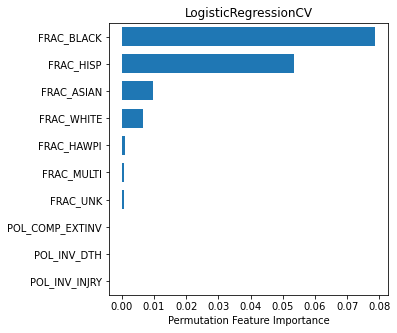

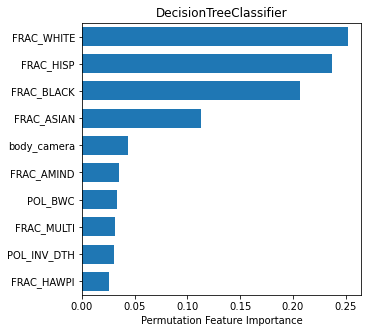

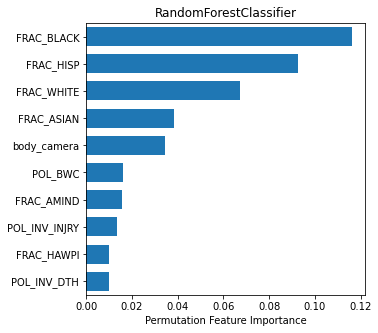

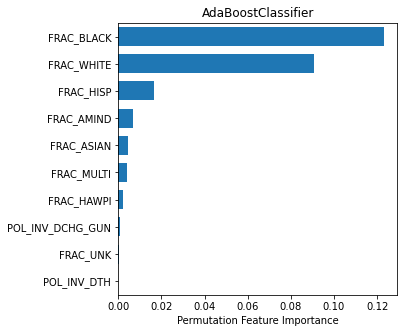

In [7]:
for model in models:
    model.importance()

<hr>

## Part 2
* Predicting race from police dept features + WaPo features. If the victim demographics are better predictors, we can tie back to EDA
* Database: victim_wapo_lemas_clean1208.csv

In [7]:
random_state = 109

# load data
data = pd.read_csv('data/victim_wapo_lemas_clean1208.csv')
response, multi_class = 'race', True
total = len(data)


# # drop unnecessary columns
# wanted to keep race as single column, multi-class
cols_to_drop = ['id', 'name', 'date', 'armed_wapo', 'gender', 'city_wapo', 'state', 
                'threat_level', 'longitude', 'latitude', 'is_geocoding_exact',
               'street_address', 'zipcode', 'county', 'ORI_agency_id', 
                'ORI9','ORI9_match_type', 'race_A', 'race_B', 
                'race_H', 'race_N', 'race_O', 'race_W', 'AGENCYNAME'] + list(data.filter(regex='PERS'))

data = data.drop(cols_to_drop, axis=1)

# drop nas
data = data.dropna()
print(f'Number of victims missing values: {total-len(data)}')

# convert booleans to integers
# bools_to_ints = ['signs_of_mental_illness', 'body_camera']
# data[bools_to_ints] = data[bools_to_ints].astype(int)

# convert response variable to 0 and n_classes-1
if multi_class:
    le = LabelEncoder()
    data[response] = le.fit_transform(data[response])
    print(f'Response variable classes: {le.classes_}')

# convert other variables to dummies
data = pd.get_dummies(data)
data.dtypes

Number of victims missing values: 324
Response variable classes: ['A' 'B' 'H' 'N' 'O' 'W']


age                        float64
race                         int64
signs_of_mental_illness      int64
body_camera                  int64
is_male                      int64
is_tasered_and_shot          int64
is_armed_gun                 int64
is_armed_knife               int64
is_unarmed                   int64
is_armed_other               int64
geo_Rural                    int64
geo_Suburban                 int64
geo_Undetermined             int64
geo_Urban                    int64
threat_attack                int64
threat_other                 int64
threat_undetermined          int64
POL_BWC                    float64
POL_COMP_EXTINV            float64
POL_INV_INJRY              float64
POL_INV_DTH                float64
POL_INV_DCHG_GUN           float64
FRAC_WHITE                 float64
FRAC_BLACK                 float64
FRAC_HISP                  float64
FRAC_AMIND                 float64
FRAC_ASIAN                 float64
FRAC_HAWPI                 float64
FRAC_MULTI          

In [8]:
# splits
rows = len(data)
train_size = 0.6
val_size = 0.2

train, validate, test = np.split(data.sample(frac=1, random_state=random_state), [int(train_size*rows), int((train_size+val_size)*rows)])

x_train, y_train = train.drop(response, axis=1), train[response]
x_val, y_val = validate.drop(response, axis=1), validate[response]
x_test, y_test = test.drop(response, axis=1), test[response]

col_labels = x_train.columns

scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

print(f'Train size: {len(train)/rows:.2f}')
print(f'Val size: {len(validate)/rows:.2f}')
print(f'Test size: {len(test)/rows:.2f}')

# np.where(x_test==x_test.min()[-1])
# x_test.iloc[315]

Train size: 0.60
Val size: 0.20
Test size: 0.20


In [9]:
# model fitting
knn = Model(KNeighborsClassifier())

logit = Model(LogisticRegression(multi_class='ovr', max_iter=1000, random_state=random_state))
logitCV = Model(LogisticRegressionCV(multi_class='ovr', max_iter=1000, random_state=random_state))

dtree = Model(DecisionTreeClassifier(random_state=random_state))
forest = Model(RandomForestClassifier(random_state=random_state))
boost = Model(AdaBoostClassifier(random_state=random_state))

models = [knn, logit, logitCV, dtree, forest, boost]

In [10]:
x = PrettyTable()
x.field_names = ["Model", "Train Accuracy", "Validation Accuracy"]
x.add_rows(
    [
        ["KNN", knn.train_accuracy(), knn.validation_accuracy()],
        ["Logistic Regression", logit.train_accuracy(), logit.validation_accuracy()],
        ["Logistic Regression CV", logitCV.train_accuracy(), logitCV.validation_accuracy()],
        ["Decision Tree", dtree.train_accuracy(), dtree.validation_accuracy()],
        ["Random Forest", forest.train_accuracy(), forest.validation_accuracy()],
        ["AdaBoost", boost.train_accuracy(), boost.validation_accuracy()]
    ]
)

x.align = "l"
x.float_format = '.3'

print('Accuracies for victim_wapo_lemas_clean1208.csv')
print(x)

Accuracies for victim_wapo_lemas_clean1208.csv
+------------------------+----------------+---------------------+
| Model                  | Train Accuracy | Validation Accuracy |
+------------------------+----------------+---------------------+
| KNN                    | 0.681          | 0.548               |
| Logistic Regression    | 0.646          | 0.630               |
| Logistic Regression CV | 0.647          | 0.622               |
| Decision Tree          | 0.999          | 0.530               |
| Random Forest          | 0.999          | 0.626               |
| AdaBoost               | 0.569          | 0.547               |
+------------------------+----------------+---------------------+


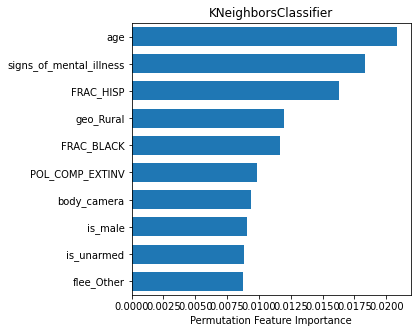

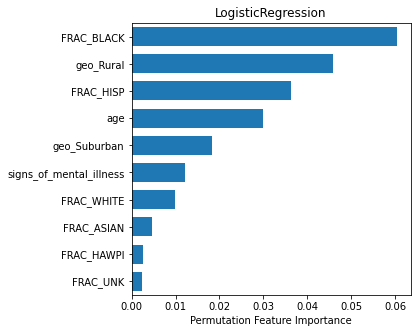

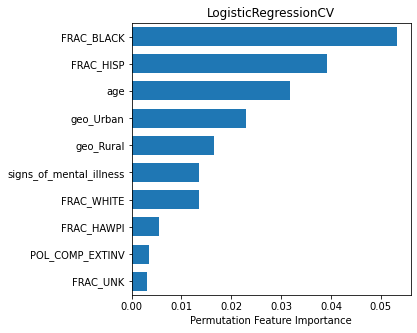

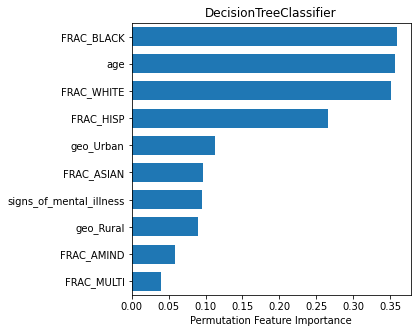

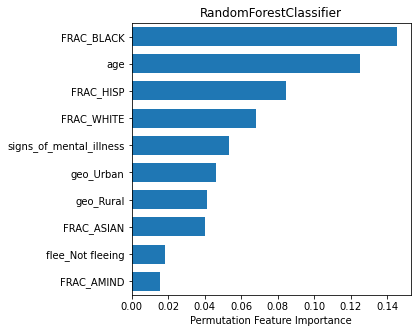

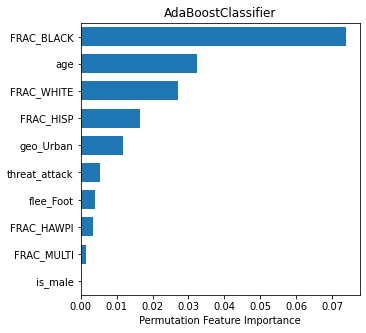

In [11]:
for model in models:
    model.importance()